# Requirement 4

FUNCTION DEFINITION AND CORE

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from bidding_agents import MultiplicativePacingAgent as PrimalDualTruthful
from bidding_agents import FFMultiplicativePacingAgent as PrimalDualNonTruthful
from bidding_agents import ucblike as UCB
import pandas as pd 


class FirstPriceAuction:
    def __init__(self, num_bidders):
        self.ctrs = np.ones(num_bidders) 
        self.n_adv = len(self.ctrs)

    def round(self, bids):
        winners, values = self.get_winners(bids) # Allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

def get_clairvoyant_truthful(B, my_valuation, m_t, t):
    utility = (my_valuation - m_t) * (my_valuation >= m_t)
    
    sorted_round_utility = np.flip(np.argsort(utility))
    
    clairvoyant_utilities = np.zeros(t)
    clairvoyant_bids = np.zeros(t)
    clairvoyant_payments = np.zeros(t)
    
    c = 0
    i = 0
    while c <= B - 1 and i < t:
        index = sorted_round_utility[i]
        clairvoyant_bids[index] = 1
        clairvoyant_utilities[index] = utility[index]
        clairvoyant_payments[index] = m_t[index]
        c += m_t[index]
        i += 1
    
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

def simulate_auction(num_bidders, budget, T, eta, valuation, bids_set, epochs=10):
    
    all_results = {i: [] for i in range(num_bidders)}
    
    for epoch in range(epochs):
        # Initialize the auction environment
        auction = FirstPriceAuction(num_bidders)

        class_instances = {
            'truthful_bidder': [],
            'non_truthful_bidder': [],
            'ucb_bidder': []
        }
    
        for i in range(num_bidders):
            if i % 3 == 0:
                class_instances['truthful_bidder'].append(PrimalDualTruthful(valuation, budget, T, eta))
            elif i % 3 == 1:
                class_instances['non_truthful_bidder'].append(PrimalDualNonTruthful(bids_set, valuation, budget, T, eta))
            else:
                class_instances['ucb_bidder'].append(UCB(budget, T, 1, valuation, discretization=20, range=0.1))

        results = {
            'truthful': {i: [] for i in range(len(class_instances['truthful_bidder']))},
            'non_truthful': {i: [] for i in range(len(class_instances['non_truthful_bidder']))},
            'ucb': {i: [] for i in range(len(class_instances['ucb_bidder']))}
        }

        utilities_t = {i: [] for i in range(len(class_instances['truthful_bidder']))}
        m_t_t = {i: np.zeros(0) for i in range(len(class_instances['truthful_bidder']))}
        utilities_nt = {i: [] for i in range(len(class_instances['non_truthful_bidder']))}
        m_t_nt = {i: np.zeros(0) for i in range(len(class_instances['non_truthful_bidder']))}
        utilities_ucb = {i: [] for i in range(len(class_instances['ucb_bidder']))}
        m_t_ucb = {i: np.zeros(0) for i in range(len(class_instances['ucb_bidder']))}
        bids_won_t = {i: [] for i in range(len(class_instances['truthful_bidder']))}
        bids_won_nt = {i: [] for i in range(len(class_instances['non_truthful_bidder']))}
        bids_won_ucb = {i: [] for i in range(len(class_instances['ucb_bidder']))}
        
        # Run the auction for the specified number of rounds
        np.random.seed(epoch)
        for t in range(T):
            bids_truthful = [instance.bid() for instance in class_instances['truthful_bidder']]
            bids_non_truthful = [instance.bid() for instance in class_instances['non_truthful_bidder']]
            bids_ucb = [instance.bid() for instance in class_instances['ucb_bidder']]

            bids = np.hstack((bids_truthful, bids_non_truthful, bids_ucb))
            
            winners, payments_per_click = auction.round(bids=bids)

            if isinstance(winners, (int, np.integer)):
                winners = [winners]

            # Update algorithms with the reward and store data
            
            for i, truthful_instance in enumerate(class_instances["truthful_bidder"]):
                other_truthful_bids = [bid for j, bid in enumerate(bids_truthful) if j != i]
                other_bids = np.hstack((other_truthful_bids, bids_non_truthful, bids_ucb))
                truthful_bid_index = i
                my_win = int(truthful_bid_index in winners)
                bids_won_t[i].append(my_win)
                m_t = other_bids.max(axis=0)
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                truthful_instance.update(f_t, c_t)
                utilities_t[i].append(f_t)
                m_t_t[i] = np.append(m_t_t[i], m_t)

            for i, non_truthful_instance in enumerate(class_instances["non_truthful_bidder"]):
                other_non_truthful_bids = [bid for j, bid in enumerate(bids_non_truthful) if j != i]
                other_bids = np.hstack((bids_truthful, other_non_truthful_bids, bids_ucb))
                non_truthful_bid_index = len(bids_truthful) + i
                my_win = int(non_truthful_bid_index in winners)
                bids_won_nt[i].append(my_win)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                non_truthful_instance.update(f_t, c_t, m_t)
                utilities_nt[i].append(f_t)
                m_t_nt[i] = np.append(m_t_nt[i], m_t)

            for i, ucb_instance in enumerate(class_instances["ucb_bidder"]):
                other_ucb_bids = [bid for j, bid in enumerate(bids_ucb) if j != i]
                other_bids = np.hstack((bids_truthful, bids_non_truthful, other_ucb_bids))
                ucb_bid_index = len(bids_truthful) + len(bids_non_truthful) + i
                my_win = int(ucb_bid_index in winners)
                bids_won_ucb[i].append(my_win)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                ucb_instance.update(f_t, c_t)
                utilities_ucb[i].append(f_t)
                m_t_ucb[i] = np.append(m_t_ucb[i], m_t)


            # Record results per each instance
            for i, bid in enumerate(bids_truthful):
                results['truthful'][i].append(bid)
            for i, bid in enumerate(bids_non_truthful):
                results['non_truthful'][i].append(bid)
            for i, bid in enumerate(bids_ucb):
                results['ucb'][i].append(bid)

            all_results[epoch] = results
    
    return results, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb



# Set parameters and run the simulation

num_bidders = 6 # this number can be changed to whatever you want, we modeled the algorithm so that the type of bidder is assigned round robin
B = 130
T = 1000
eta = 1/np.sqrt(T)
my_valuation = 0.6
available_bids = np.linspace(0,1,11)

results, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Compute the cumulative results

cumulative_results_truthful = {i: np.cumsum(results['truthful'][i]) for i in results['truthful']}
cumulative_results_non_truthful = {i: np.cumsum(results['non_truthful'][i]) for i in results['non_truthful']}
cumulative_results_ucb = {i: np.cumsum(results['ucb'][i]) for i in results['ucb']}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

# Main Results 

In [48]:
final_cumulative_results_truthful = {i: np.sum(results['truthful'][i]) for i in results['truthful']}
final_cumulative_results_non_truthful = {i: np.sum(results['non_truthful'][i]) for i in results['non_truthful']}
final_cumulative_results_ucb = {i: np.sum(results['ucb'][i]) for i in results['ucb']}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_results_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_results_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_results_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_results_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_results_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_results_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1          313.900000            8.377259                  125
1  Non-Truthful 2          298.700000            7.176789                  122
2      Truthful 1          518.556636            9.040615                  183
3      Truthful 2          519.393874            9.003690                  182
4           UCB 1          359.810526            9.294484                  154
5           UCB 2          379.105263           13.846662                  234


# Payments

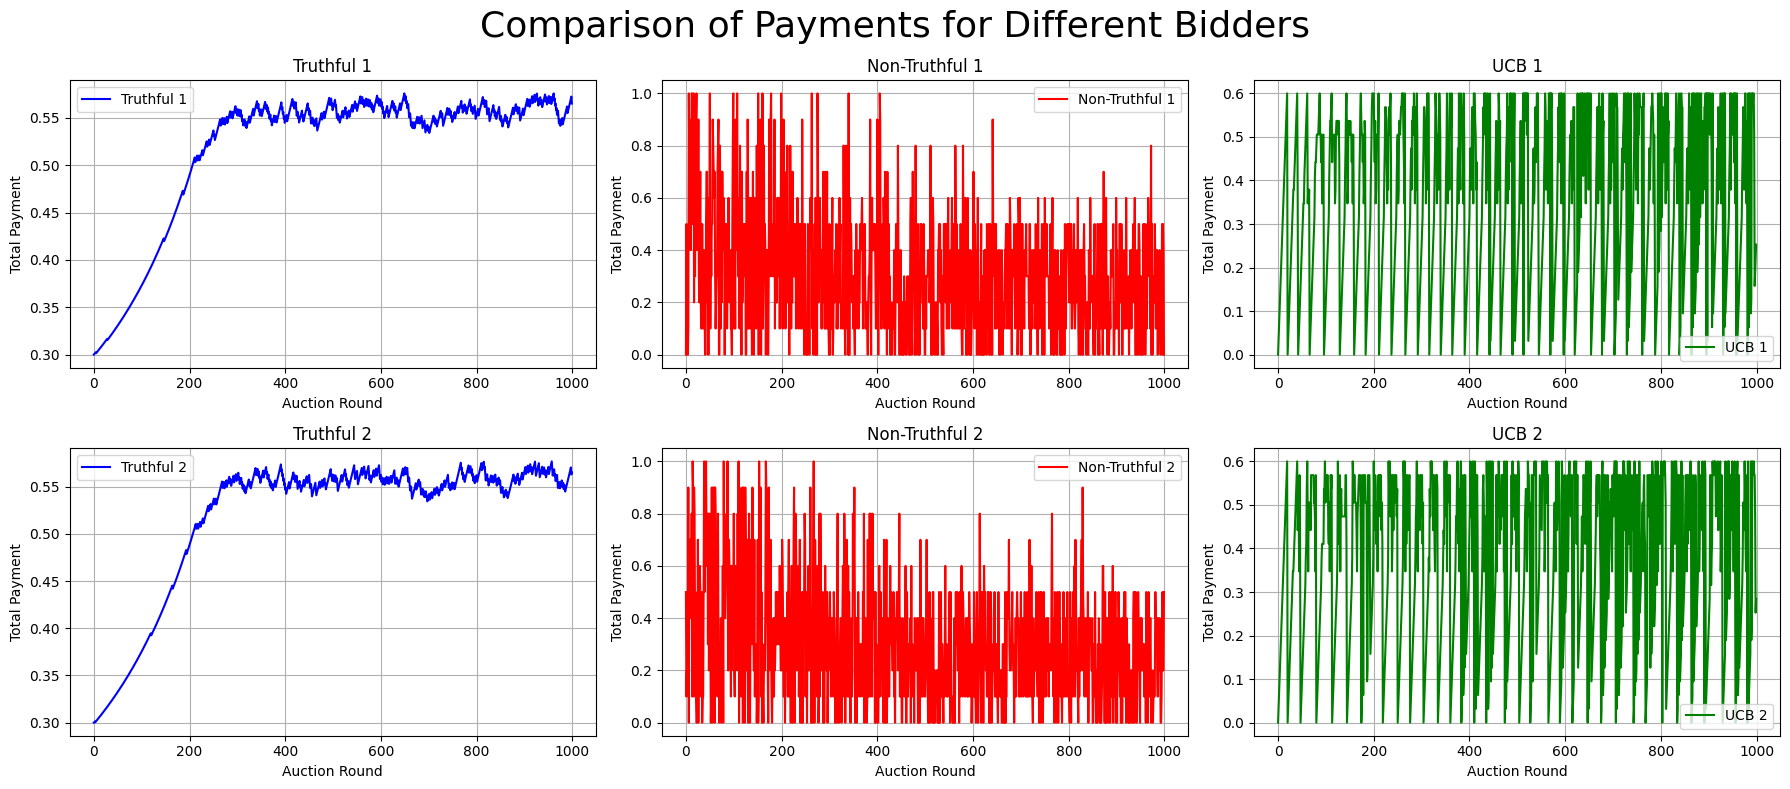

In [49]:
# Plot the results
total_truthful = len(results['truthful'])
total_non_truthful = len(results['non_truthful'])
total_ucb = len(results['ucb'])

num_rows = max(total_truthful, total_non_truthful, total_ucb)
num_cols = 3 

fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot results['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(results['truthful'][i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Total Payment')
    else:
        ax[row, 0].plot(results['truthful'][i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Total Payment')

# Plot results['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Total Payment')
    else:
        ax[row, 1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Total Payment')

# Plot results['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(results['ucb'][i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Total Payment')
    else:
        ax[row, 2].plot(results['ucb'][i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Total Payment')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Payments for Different Bidders', fontsize=26)

plt.tight_layout()
plt.show()

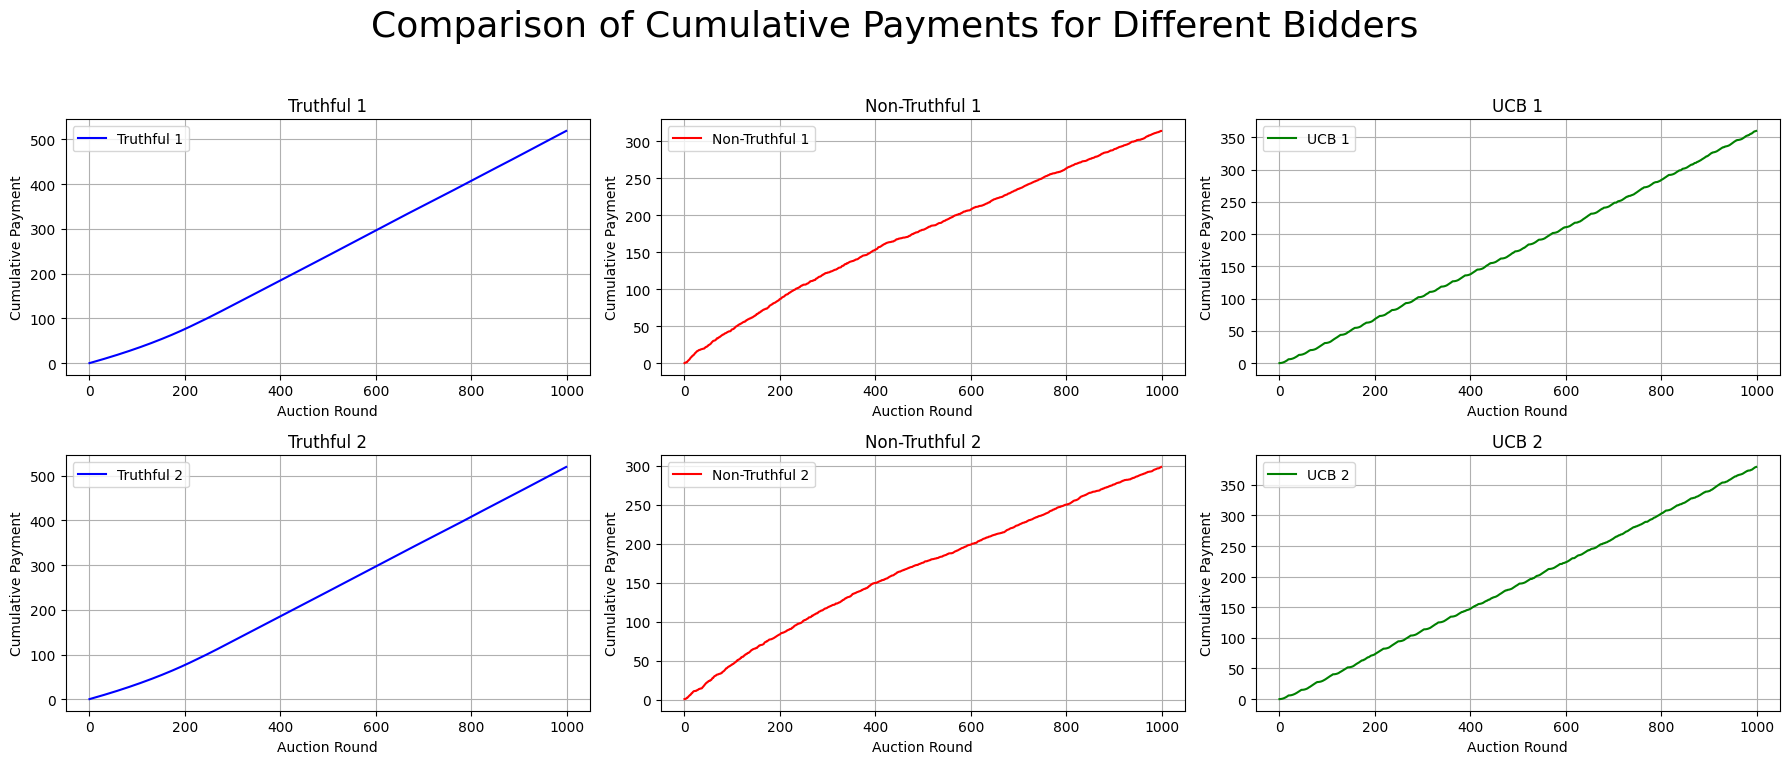

In [50]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative results['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_results_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Cumulative Payment')
    else:
        ax[row, 0].plot(cumulative_results_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Cumulative Payment')

# Plot cumulative results['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_results_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Cumulative Payment')
    else:
        ax[row, 1].plot(cumulative_results_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Cumulative Payment')

# Plot cumulative results['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_results_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Cumulative Payment')
    else:
        ax[row, 2].plot(cumulative_results_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Cumulative Payment')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Payments for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# Utilities

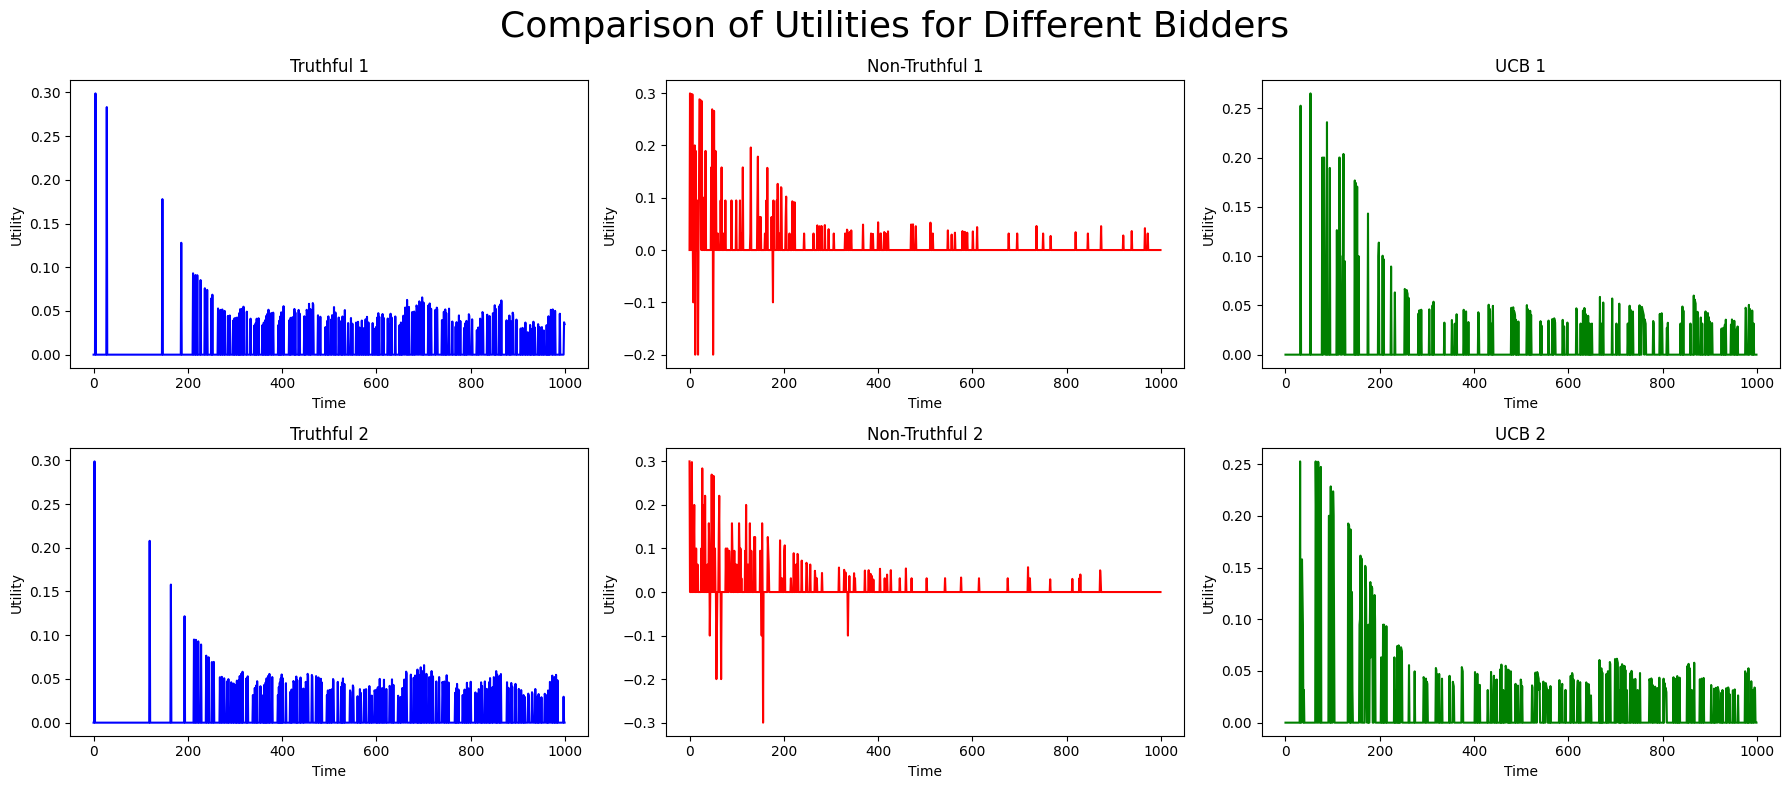

In [51]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot utilities_t
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Utility')
    else:
        ax[row, 0].plot(utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Time')
        ax[row, 0].set_ylabel('Utility')

# Plot utilities_nt
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Utility')
    else:
        ax[row, 1].plot(utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Time')
        ax[row, 1].set_ylabel('Utility')

# Plot utilities_ucb
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Time')
        ax[0, 2].set_ylabel('Utility')
    else:
        ax[row, 2].plot(utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Time')
        ax[row, 2].set_ylabel('Utility')

fig.suptitle('Comparison of Utilities for Different Bidders', fontsize=26)

plt.tight_layout()
plt.show()

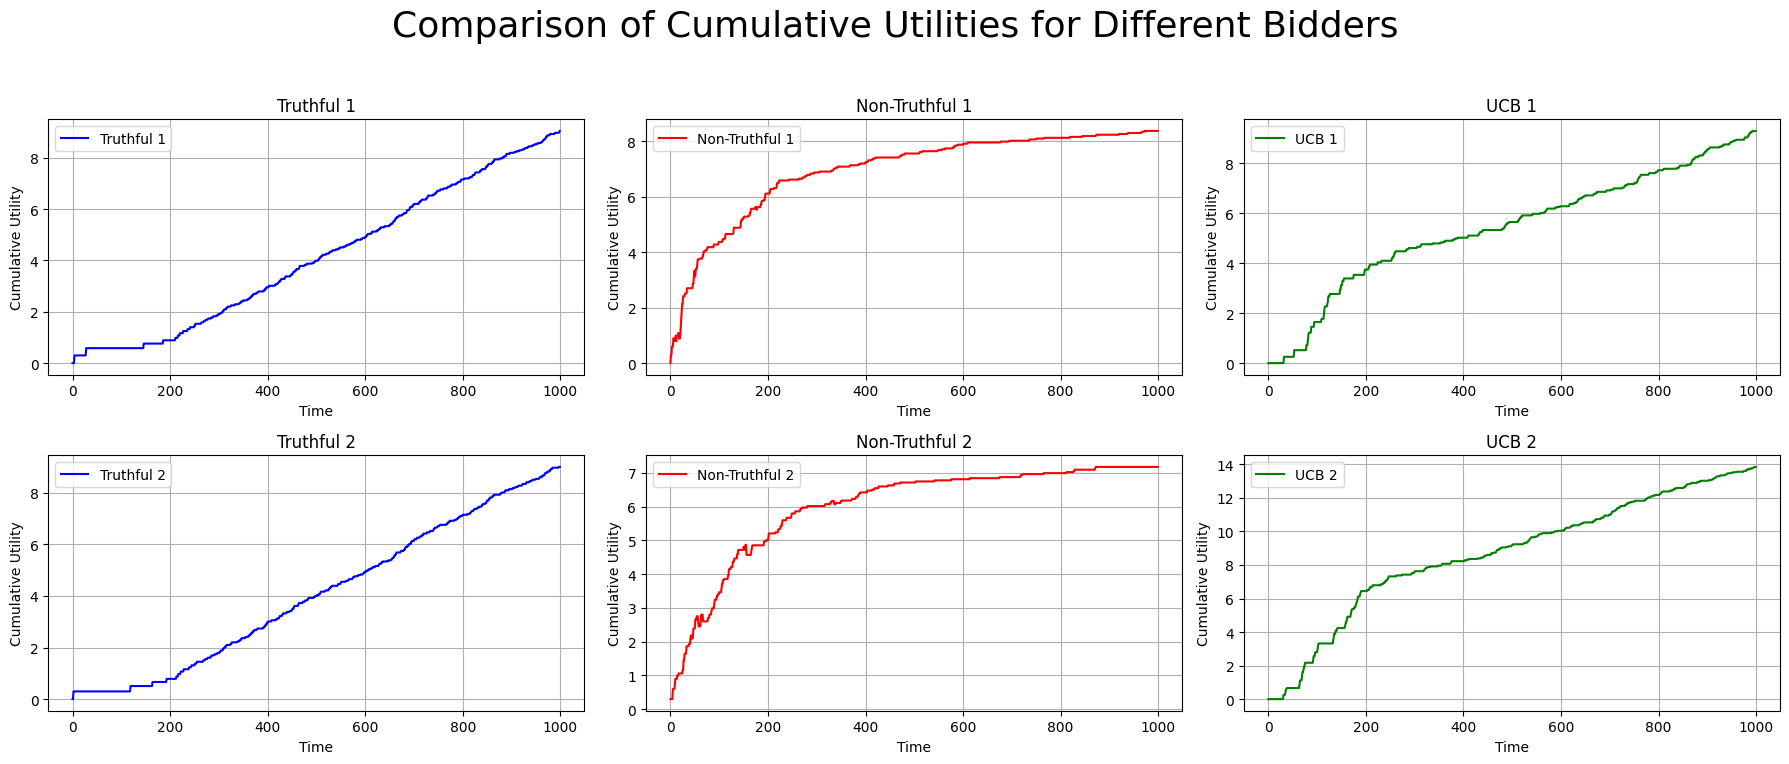

In [52]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative utilities_t
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Cumulative Utility')
    else:
        ax[row, 0].plot(cumulative_utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Time')
        ax[row, 0].set_ylabel('Cumulative Utility')

# Plot cumulative utilities_nt
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Cumulative Utility')
    else:
        ax[row, 1].plot(cumulative_utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Time')
        ax[row, 1].set_ylabel('Cumulative Utility')

# Plot cumulative utilities_ucb
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Time')
        ax[0, 2].set_ylabel('Cumulative Utility')
    else:
        ax[row, 2].plot(cumulative_utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Time')
        ax[row, 2].set_ylabel('Cumulative Utility')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Utilities for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Bids won 

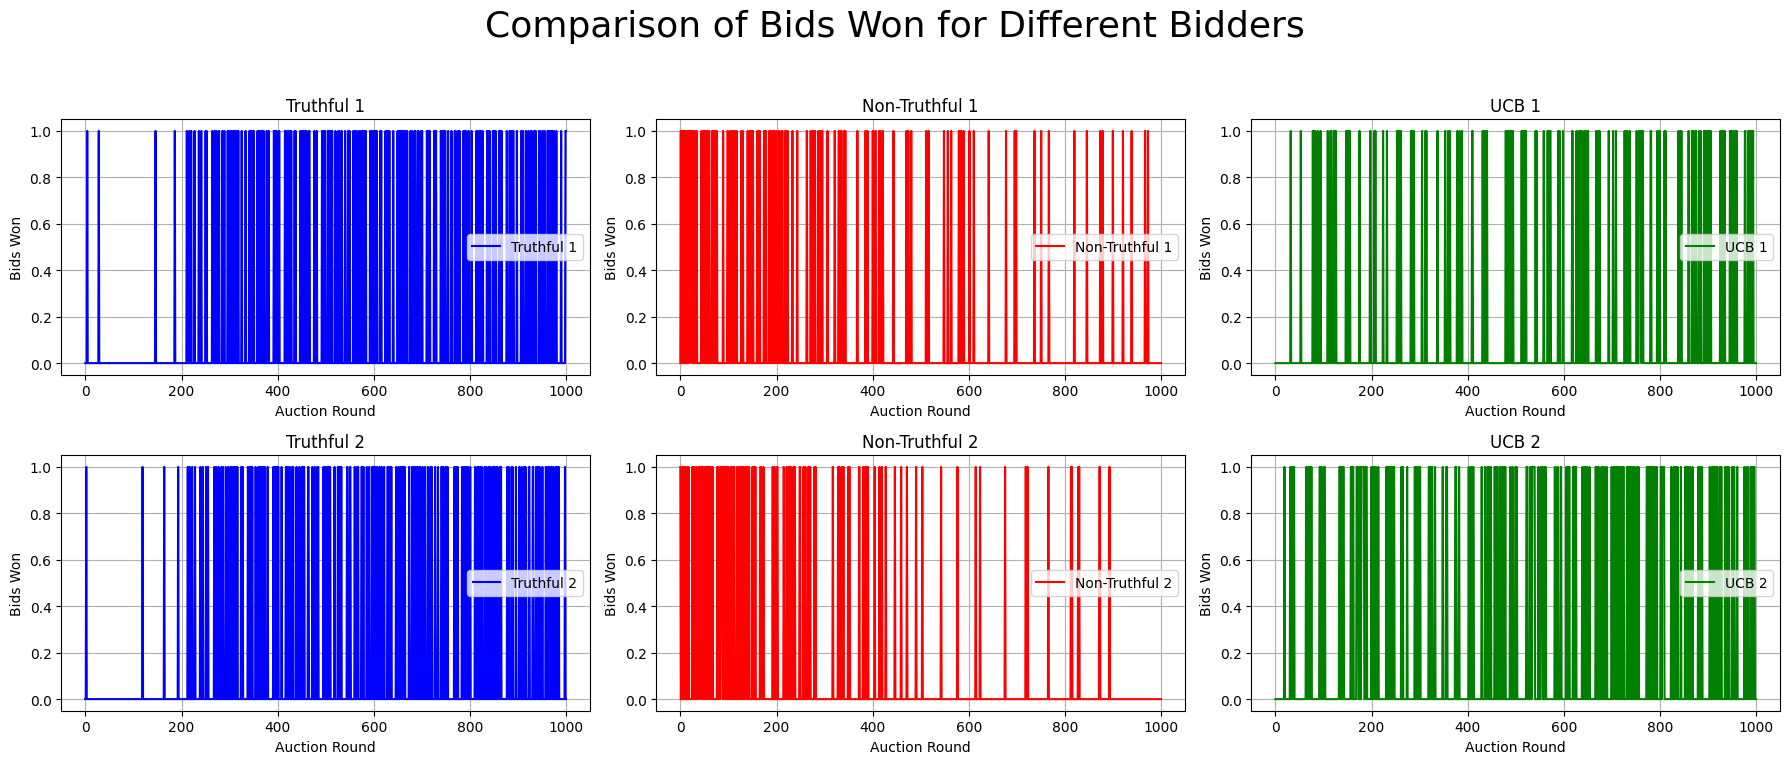

In [53]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot bids_won['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(bids_won_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Bids Won')
    else:
        ax[row, 0].plot(bids_won_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Bids Won')

# Plot bids_won['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(bids_won_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Bids Won')
    else:
        ax[row, 1].plot(bids_won_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Bids Won')

# Plot bids_won['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Bids Won')
    else:
        ax[row, 2].plot(bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Bids Won')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Bids Won for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

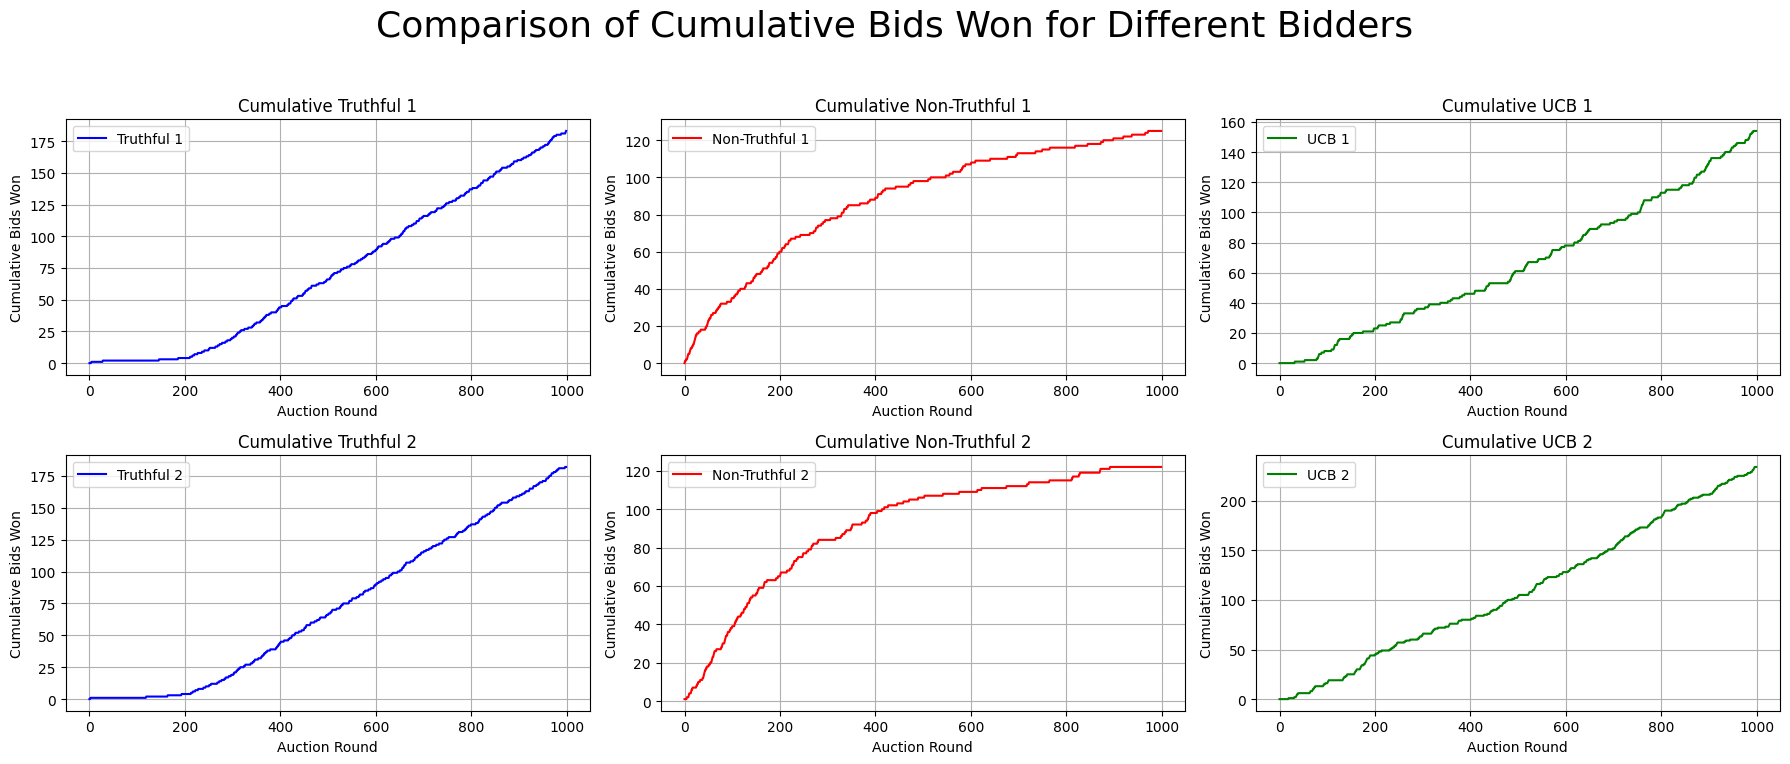

In [54]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative bids_won['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_bids_won_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Cumulative Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 0].plot(cumulative_bids_won_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Cumulative Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Cumulative Bids Won')

# Plot cumulative bids_won['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_bids_won_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Cumulative Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 1].plot(cumulative_bids_won_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Cumulative Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Cumulative Bids Won')

# Plot cumulative bids_won['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'Cumulative UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 2].plot(cumulative_bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'Cumulative UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Cumulative Bids Won')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Bids Won for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# Changing Parameters

CHANGING my_valuation 

In [55]:
num_bidders = 6 
B = 130
T = 1000
eta = 1/np.sqrt(T)
my_valuation = 0.4
available_bids = np.linspace(0,1,11)

results, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

cumulative_results_truthful = {i: np.cumsum(results['truthful'][i]) for i in results['truthful']}
cumulative_results_non_truthful = {i: np.cumsum(results['non_truthful'][i]) for i in results['non_truthful']}
cumulative_results_ucb = {i: np.cumsum(results['ucb'][i]) for i in results['ucb']}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

In [56]:
final_cumulative_results_truthful = {i: np.sum(results['truthful'][i]) for i in results['truthful']}
final_cumulative_results_non_truthful = {i: np.sum(results['non_truthful'][i]) for i in results['non_truthful']}
final_cumulative_results_ucb = {i: np.sum(results['ucb'][i]) for i in results['ucb']}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_results_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_results_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_results_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_results_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_results_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_results_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1          264.400000            3.492192                  215
1  Non-Truthful 2          248.500000            0.389746                  194
2      Truthful 1          362.419431            2.992509                  235
3      Truthful 2          362.527705            3.099577                  240
4           UCB 1          206.084211            1.301144                   57
5           UCB 2          207.726316            1.578647                   59


CHANGING eta

In [57]:
num_bidders = 6 
B = 130
T = 1000
eta = 0.1
my_valuation = 0.4
available_bids = np.linspace(0,1,11)

results, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

cumulative_results_truthful = {i: np.cumsum(results['truthful'][i]) for i in results['truthful']}
cumulative_results_non_truthful = {i: np.cumsum(results['non_truthful'][i]) for i in results['non_truthful']}
cumulative_results_ucb = {i: np.cumsum(results['ucb'][i]) for i in results['ucb']}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

In [58]:
final_cumulative_results_truthful = {i: np.sum(results['truthful'][i]) for i in results['truthful']}
final_cumulative_results_non_truthful = {i: np.sum(results['non_truthful'][i]) for i in results['non_truthful']}
final_cumulative_results_ucb = {i: np.sum(results['ucb'][i]) for i in results['ucb']}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_results_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_results_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_results_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_results_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_results_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_results_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1          257.700000           -0.022027                  206
1  Non-Truthful 2          238.600000           -2.221030                  178
2      Truthful 1          381.219970            3.853234                  249
3      Truthful 2          380.504927            3.690749                  268
4           UCB 1          202.842105            0.477464                   48
5           UCB 2          202.968421            0.675863                   51
